# Решение тестового задания для вакансии «Младший исследователь данных (DS)»

In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
import plotly as py

Чтение данных из файла (используется кодировка cp1251 для корректного отображения всех символов, убираются все лишние двойные кавычки)
Далее колонки "Количество больничных дней" и "Возраст" приводятся к типу данных int64 (из numpy)

In [14]:
df = pd.read_csv("М.Тех_Данные_к_ТЗ_DS.csv", encoding='cp1251', sep="\,", engine="python", header=None).apply(lambda x: x.str.replace(r"\"","", regex=True))
df.columns = df.iloc[0]
df.drop(index=0, inplace=True)
df.head()
df["Количество больничных дней"] = df["Количество больничных дней"].astype(np.int_)
df["Возраст"] = df["Возраст"].astype(np.int_)

PermissionError: [Errno 1] Operation not permitted: 'М.Тех_Данные_к_ТЗ_DS.csv'

Вывод информации о датафрейме (нет пропусков в данных, типы данных корректные)

In [ ]:
df.info()

Гистограммы распределений колонок "Возраст" и "Количество больничных дней"

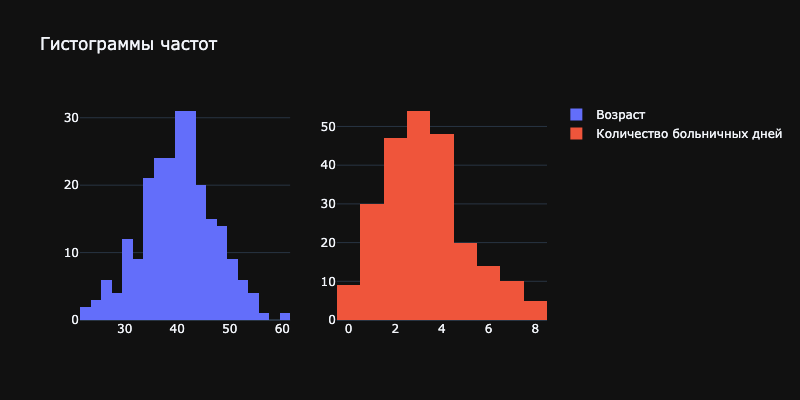

In [15]:
fig = make_subplots(rows=1, cols=2)

trace0 = go.Histogram(x=df["Возраст"], name="Возраст")
trace1 = go.Histogram(x=df["Количество больничных дней"], name="Количество больничных дней")

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig.update_layout(title_text="Гистограммы частот", width=800, height=400)

fig.show("png")

## Вспомогательные функции

In [16]:
def plot_density_func(stat, alpha):
    r = stats.norm.ppf([1 - alpha], 0, 1).item()
    x1 = np.arange(-3, 3, 0.01)
    y1 = stats.norm.pdf(x1)
    x2 = np.arange((r // 0.01) * 0.01, 3, 0.01)
    y2 = stats.norm.pdf(x2)

    x3 = np.arange(stat, 3, 0.01)
    y3 = stats.norm.pdf(x3)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x1, y=y1, fill='tozeroy', mode='none', fillcolor="rgba(165, 165, 165, 0.5)",
                             name=r"$f(z|H_0)$"
                             ))
    fig.add_trace(go.Scatter(x=x2, y=y2, fill='tozeroy', mode='none', fillcolor="rgba(255, 94, 94, 0.5)",
                             name="critical area"
                             ))
    fig.add_trace(go.Scatter(x=x3, y=y3, fill='tozeroy', mode='none', fillcolor="rgba(109, 141, 255, 0.5)",
                             name="p-value"
                             ))
    fig.update_layout(title_text="Функция плотности f(z|H_0), критическая область и p-value")
    return fig.show("png")

In [17]:
# функция для вывода результатов
def print_test_result(alpha, pvalue, hypothesis_name):
    h0_accepted = pvalue > alpha
    print(f"p-value = {pvalue}, alpha = {alpha}")

    if h0_accepted:
        print("p-value > alpha")
        print("Гипотеза H_0 принимается!")
        print(f"ВЫВОД: нельзя утверждать, что {hypothesis_name}")
    else:
        print("p-value < alpha")
        print("Гипотеза H_0 отклоняется!")
        print(f"ВЫВОД: можно утверждать, что {hypothesis_name}")

## Проверить гипотезу: "Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин."

**1. Сформулируем $H_0$ и $H'$:**
Пусть проводится две серии испытаний по схеме Бернулли 
 - "успех" в первой серии A = \{Мужчина пропускает в течение года более 2 рабочих дней (work_days) по болезни\}
 - "успех" во второй серии B = \{Женщина пропускает в течение года более 2 рабочих дней (work_days) по болезни\}

Тогда вероятностей «успехов» $p_1$ и $p_2$ в этих сериях:
 - $p_1$ = P(A), 
 - $p_2$ = P(B)

Исходя из условия получаем гипотезы (two-proportion z-test):
$
\begin{gather}
H_0: p_1 = p_2
\\
H': p_1 > p_2
\end{gather}
$

**2. Зададим уровень значимости $\alpha$**
Пусть $\alpha$ = 0.05

**3. Статистика критерия $Z$ для проверки гипотезы $H_0$**
$
Z=\frac{H_1-H_2}{\sqrt{H(1-H)}\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}
$,
где
- $H_1$, $H_2$ – частоты успеха в первой серии и во второй соответственно
- $H=\frac{n_1H_1+n_2H_2}{n_1+n_2}$ – эффективная оценка истинной вероятности $p$ при условии истинности $H_0$ (т.е. при $p_1=p_2=p$ ) 
- $n_1$, $n_2$ – количество испытаний в первой серии и во второй соответственно

**4. Закон распределения $f(z|H_0)$**
$f(z|H_0)\sim N(0,1)$

**5. Критическая область**
Исходя из альтернативной гипотезы критическая область выбирается правосторонней

Таким образом, нам для проверки гипотезы требуется найти 
- общее количество мужчин = $n_1$ (далее n_1)
- общее количество женщин = $n_2$ (далее n_2)
- количество мужчин, пропускающих в течение года более 2 рабочих дней (work_days) по болезни (далее n_pass_1)
- количество женщин, пропускающих в течение года более 2 рабочих дней (work_days) по болезни (далее n_pass_2)

In [18]:
WORK_DAYS = 2
ALPHA = 0.05

# группируя по полу и считая количество по каждому разбиению получаем необходимые n_1 и n_2
work_days_total = df.groupby("Пол").size()
n_1, n_2 = work_days_total[["М", "Ж"]]

# используя условие на "Количество больничных дней", группируя по полу и считая количество по каждому разбиению 
# получаем необходимые n_pass_1 и n_pass_2
work_days_greater = df[(df["Количество больничных дней"] > WORK_DAYS)].groupby("Пол").size()
n_pass_1, n_pass_2 = work_days_greater[["М", "Ж"]]

Проводим проверку статистической гипотезы

In [19]:
# с помощью proportions_ztest считаем выборочное значение статистики критерия и p-value 
# (используется флаг alternative="larger", т.к. H': p_1 > p_2)
count = np.array([n_pass_1, n_pass_2])
nobs = np.array([n_1, n_2])
test1_stat, test1_pval = proportions_ztest(count, nobs, alternative="larger")
h_name = f"мужчины пропускают в течение года более {WORK_DAYS} рабочих дней (work_days) по болезни значимо чаще женщин"
print_test_result(ALPHA, test1_pval, h_name)

p-value = 0.8945771189806193, alpha = 0.05
p-value > alpha
Гипотеза H_0 принимается!
ВЫВОД: нельзя утверждать, что мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин


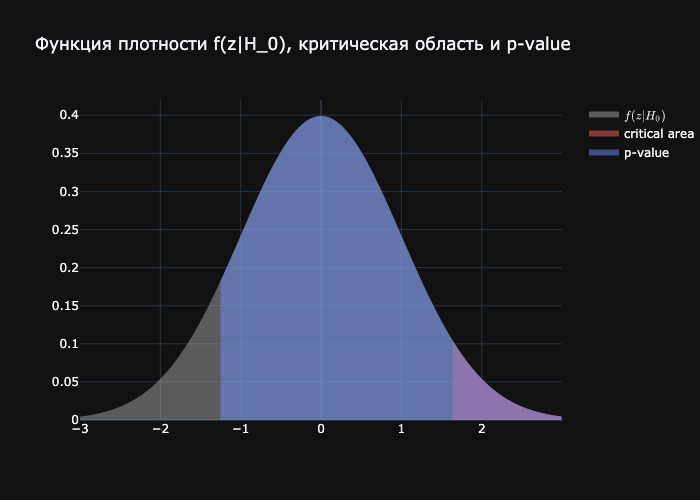

In [20]:
# построим график для наглядного отображения результата
plot_density_func(test1_stat, ALPHA)

## Проверить гипотезу: "Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег."

В данном случае разбиение на группы идет уже по признаку "Возраст".
Аналогично предыдущему тесту:

**1. Сформулируем $H_0$ и $H'$:**
Пусть проводится две серии испытаний по схеме Бернулли 
 - "успех" в первой серии A = \{Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни\}
 - "успех" во второй серии B = \{Работники младше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни\}

Тогда вероятностей «успехов» $p_1$ и $p_2$ в этих сериях:
 - $p_1$ = P(A), 
 - $p_2$ = P(B)

Исходя из условия получаем гипотезы (two-proportion z-test):
$
\begin{gather}
H_0: p_1 = p_2
\\
H': p_1 > p_2
\end{gather}
$

**2. Зададим уровень значимости $\alpha$**
Пусть $\alpha$ = 0.05

**3. Статистика критерия $Z$ для проверки гипотезы $H_0$**
$
Z=\frac{H_1-H_2}{\sqrt{H(1-H)}\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}
$,
где
- $H_1$, $H_2$ – частоты успеха в первой серии и во второй соответственно
- $H=\frac{n_1H_1+n_2H_2}{n_1+n_2}$ – эффективная оценка истинной вероятности $p$ при условии истинности $H_0$ (т.е. при $p_1=p_2=p$ ) 
- $n_1$, $n_2$ – количество испытаний в первой серии и во второй соответственно

**4. Закон распределения $f(z|H_0)$**
$f(z|H_0)\sim N(0,1)$

**5. Критическая область**
Исходя из альтернативной гипотезы критическая область выбирается правосторонней

Таким образом, нам для проверки гипотезы требуется найти 
- общее количество людей, старше 35 лет (age) = $n_1$ (далее n_1)
- общее количество людей, младше 35 лет (age) = $n_2$ (далее n_2)
- количество людей, старше 35 лет (age), пропускающих в течение года более 2 рабочих дней (work_days) по болезни (далее n_pass_1)
- количество людей, младше 35 лет (age), пропускающих в течение года более 2 рабочих дней (work_days) по болезни (далее n_pass_2)

In [21]:
WORK_DAYS = 2
AGE = 35
ALPHA = 0.05

# используя условие на "Возраст" получаем необходимые n_1 и n_2
n_1 = len(df[df["Возраст"] > AGE]["Возраст"])
n_2 = len(df[df["Возраст"] <= AGE]["Возраст"])

# используя условие на "Количество больничных дней" находим всех людей, которые пропустили по болезни больше WORK_DAYS
# далее используем условие на количество лет AGE и находим искомые n_pass_1 и n_pass_2
sick_days_greater = df[(df["Количество больничных дней"] > WORK_DAYS)]["Возраст"]
n_pass_1 = len(sick_days_greater[sick_days_greater > AGE])
n_pass_2 = len(sick_days_greater[sick_days_greater <= AGE])

Проводим проверку статистической гипотезы

In [22]:
# с помощью proportions_ztest считаем выборочное значение статистики критерия и p-value 
# (используется флаг alternative="larger", т.к. H': p_1 > p_2)
count = np.array([n_pass_1, n_pass_2])
nobs = np.array([n_1, n_2])
test1_stat, test1_pval = proportions_ztest(count, nobs, alternative="larger")
h_name = f"работники старше {AGE} лет (age) пропускают в течение года более {WORK_DAYS} рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег"
print_test_result(ALPHA, test1_pval, h_name)

p-value = 0.46016082212231335, alpha = 0.05
p-value > alpha
Гипотеза H_0 принимается!
ВЫВОД: нельзя утверждать, что работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег


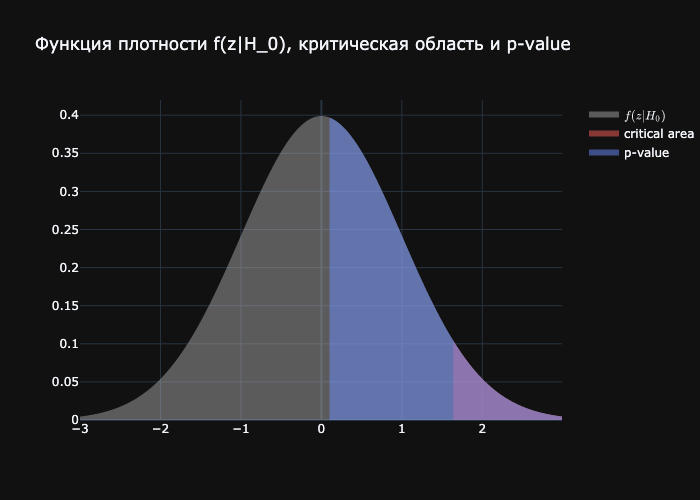

In [23]:
# построим график для наглядного отображения результата
plot_density_func(test1_stat, ALPHA)